# Homework 2

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn

In [ ]:
from google.colab import files

uploaded = files.upload()

In [6]:
# loading data

# data for Problem 1
t_obs, y_obs = np.genfromtxt("planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

# data for Problem 3
data = pd.read_csv("hr.csv")
mapper = {
    "Dwarf": 0,
    "Giant": 1,
    "Supergiant": 2
}
data['Type'] = data['Type'].map(mapper)

X_stars = data[['Magnitude', 'Temperature']].values
y_stars = data['Type'].values

from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

In [48]:
# loading data

# data for Problem 1
index, t_obs, y_obs = np.genfromtxt("planet-obs-alternate.csv",skip_header=1, delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

# data for Problem 3
data = pd.read_csv("hr.csv")
mapper = {
    "Dwarf": 0,
    "Giant": 1,
    "Supergiant": 2
}
data['Type'] = data['Type'].map(mapper)

X_stars = data[['Magnitude', 'Temperature']].values
y_stars = data['Type'].values

from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

# Problem 1

## Problem 1 Subpart 1

In [49]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a 1D numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)

    """
    # Can't do [1, t, t**2] bc those are scalars
    return np.column_stack((np.ones(len(t)), t, t**2))
    pass

def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    return np.column_stack((np.ones(len(t)), t, t**2, t**3, t**4, t**5))
    pass

In [50]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta # eta is the learning rate
        self.runs = runs
        self.W = None

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (d x 1), where d is the number of dimensions of transformed feature values.
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        # to update our parameters, we take a small step opposing gradient of objective function wrt weight parameters w^t
        # we do it for the num. of runs

        for _ in range(self.runs):
          # from def. 3.6.2, we know to use the sigmoid function
          sigtrans = sigmoid(np.dot(x, self.W))
          grad = np.dot(x.T, (sigtrans - y)) / len(x)
          self.W -= self.eta * grad

        pass

    def predict(self, x):
        """
        Predict classification probability of transformed input x

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        # TODO
        # this is just the sigmoid result, since it is used to squash btwn 0 to 1 for probs
        return sigmoid(np.dot(x, self.W))
        pass

In [9]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Pass


Note: Students have reported local issues with passing the basis 3 test case. Try running on Google Colab if only basis 3 test is failing.  

## Plotting Functions for Problem 1, Subpart 2

In [51]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig(title + '.png')
    plt.show()

In [52]:
# You may find it helpful to modify this function for Problem 1, Subpart 4,
# but do not change the existing code--add your own variables
def plot_results(basis, title):
    eta = 0.001
    runs = 10000

    # My code
    # Initialize x and y
    x_01 = basis(np.array([0.1]))
    x_32 = basis(np.array([3.2]))
    x_50 = basis(np.array([5.0]))
    y_01 = []
    y_32 = []
    y_50 = []


    # Existing code
    all_models = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

        # My code
        y_01.append(model.predict(x_01))
        y_32.append(model.predict(x_32))
        y_50.append(model.predict(x_50))

    visualize_prediction_lines(x, y, all_models, basis, title)

    print("Predicted value, t = 0.1: " + str(y_01[0]))
    print("Predicted value, t = 3.2: " + str(y_32[0]))
    print("Predicted value, t = 5.0: " + str(y_50[0]))
    print("Variance of all models, t = 0.1: " + str(np.var(y_01)))
    print("Variance of all models, t = 3.2: " + str(np.var(y_32)))
    print("Variance of all models, t = 5.0: " + str(np.var(y_50)))



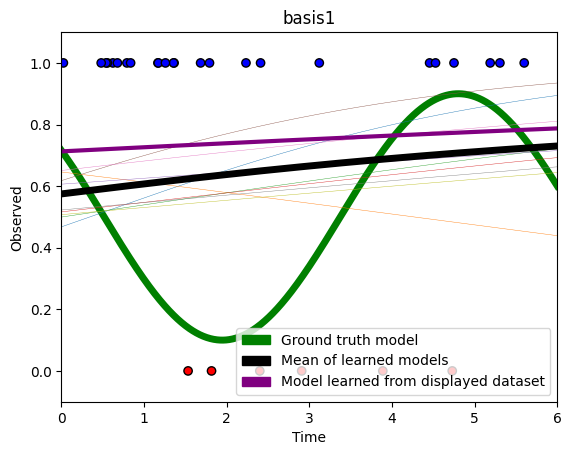

Predicted value, t = 0.1: [[0.47700938]]
Predicted value, t = 3.2: [[0.74638321]]
Predicted value, t = 5.0: [[0.85316042]]
Variance of all models, t = 0.1: 0.005837732239630753
Variance of all models, t = 3.2: 0.00822848829445331
Variance of all models, t = 5.0: 0.014124378357976312


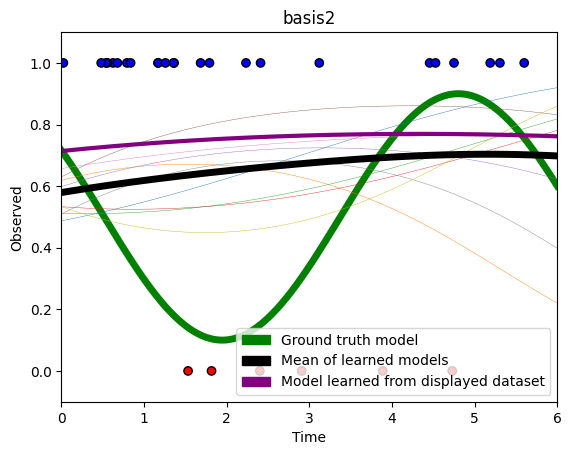

Predicted value, t = 0.1: [[0.49245403]]
Predicted value, t = 3.2: [[0.72609291]]
Predicted value, t = 5.0: [[0.86472281]]
Variance of all models, t = 0.1: 0.005309628271471565
Variance of all models, t = 3.2: 0.009547989507323228
Variance of all models, t = 5.0: 0.018747482348891918


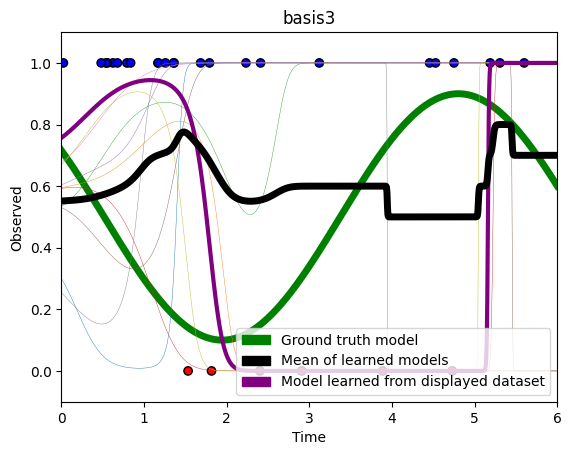

Predicted value, t = 0.1: [[0.25010349]]
Predicted value, t = 3.2: [[1.]]
Predicted value, t = 5.0: [[1.]]
Variance of all models, t = 0.1: 0.030056804138743065
Variance of all models, t = 3.2: 0.23999999815922002
Variance of all models, t = 5.0: 0.24999833999238338


In [53]:
plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

# Problem 3

In [20]:
class GaussianGenerativeModel:
    def __init__(self, is_shared_covariance=False):
        self.is_shared_covariance = is_shared_covariance

    def fit(self, X, y):
        """
        Compute the means and (shared) covariance matrix of the data. Compute the prior over y.

        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """

        classes = np.unique(y) # in this case, 0, 1, 2
        self.means = []
        self.priors = [0] * len(classes) # bc you need one for each class

        # Initialize shared covariance matrix
        self.shared_covariance = np.zeros((2,2))

        # Normal covariance matrix
        self.covariances = []

        for c in classes:
          X_here = X[y == c]
          self.priors[c] = len(X_here) / len(X)

          # Calculate the means
          self.means.append(np.mean(X_here, axis = 0))

          # Modify Sigma
          # Check if shared covariance
          covar = np.cov(X_here, rowvar=False)
          if self.is_shared_covariance:
            self.shared_covariance += self.priors[c] * covar
          else:
            self.covariances.append(covar)


    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.

        Predict classes of points given feature values in X_pred

        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        preds = []
        for cls in range(len(self.means)): # for each class

            if self.is_shared_covariance:
                cov = self.shared_covariance
            else:
                cov = self.covariances[cls]

            preds.append(mvn.pdf(X_pred, self.means[cls], cov))
        preds = np.array(preds)
        if preds.ndim == 1:
            preds = np.reshape(preds, (preds.shape[0], 1))

        print(preds)
        return np.argmax(preds.T, axis=1)



    def negative_log_likelihood(self, X, y):
        """
        Given the data X, use previously calculated class means and covariance matrix to
        calculate the negative log likelihood of the data
        """
        nll = 0
        for c, mean in enumerate(self.means):
          X_here = X[y == c]
          pdf_values = mvn.logpdf(X_here, mean=mean, cov=self.shared_covariance)
          prior = self.priors[c]
          nll += -np.sum(pdf_values) * prior

        return nll
        # TODO


In [24]:
class SoftmaxRegression:
    def __init__(self, eta, lam):
        self.eta = eta
        self.lam = lam
        self.W = None
        self.runs = 200000

    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        Use the results from Problem 2 to find an expression for the gradient

        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        # Initializing the weights (do not change!)
        # The number of classes is 1 + (the highest numbered class)
        #  bias trick
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)

        # Initializing the weights (do not change!)
        # The number of classes is 1 + (the highest numbered class)
        classes = y.max() + 1
        features = X.shape[1]
        self.W = np.ones( (classes, features) )

        y = np.eye(classes)[y]
        for i in range(self.runs):
            y_pred = softmax(np.dot(X, self.W.T), axis = 1)
            grad = np.dot((y_pred - y).T, X) + self.W * self.lam
            self.W -= grad * self.eta

        pass

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.

        Predict classes of points given feature values in X_pred

        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        # TODO
        X_pred = np.column_stack([np.ones(X_pred.shape[0]), X_pred])
        return np.argmax(np.dot(X_pred, self.W.T), axis=1)


    def predict_proba(self, X_pred):
        """
        Predict classification probabilities of points given feature values in X_pred

        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Dwarf=index 0, Giant=index 1, Supergiant=index 2).
                 Shape should be (n x 3)
        """
        X_pred = np.column_stack([np.ones(X_pred.shape[0]), X_pred])
        return softmax(np.dot(X_pred, self.W.T), axis=1)
        pass

In [25]:
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k

    def distance(self, x, x_i):
      return ((x[0] - x_i[0])**2/9) + (x[1] - x_i[1])**2

    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.

        Predict classes of points given feature values in X_pred

        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        preds = []
        for x in X_pred:
            distances = []
            for x_i, y_i in zip(self.X, self.y):
                distances.append(((x[0] - x_i[0])**2/9) + (x[1] - x_i[1])**2)
                # tried abstracting but failed el oh el

            both = [(d, y) for d, y in zip(distances, self.y)]
            both.sort(key=lambda z: z[0])
            knn = both[:self.K]
            preds.append(np.argmax(np.bincount([y for d, y in knn])))
        return np.array(preds)

In [30]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    # basis function
    # to start we write code to transform the coords then we put them tgt
    first = np.log(10 + X[:, 0])
    second = (X[:, 1])**2
    return np.stack([first, second], axis = 1)

## Plotting Function for Problem 3, Subpart 1

In [31]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=2):
    # Create a grid of points
    x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
    y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T

    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Magnitude')
    plt.ylabel('Temperature')
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Dwarf')
    blue = mpatches.Patch(color='blue', label='Giant')
    green = mpatches.Patch(color='green', label='Supergiant')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig(title + '.png')
    plt.show()

## Problem 3, Subpart 1

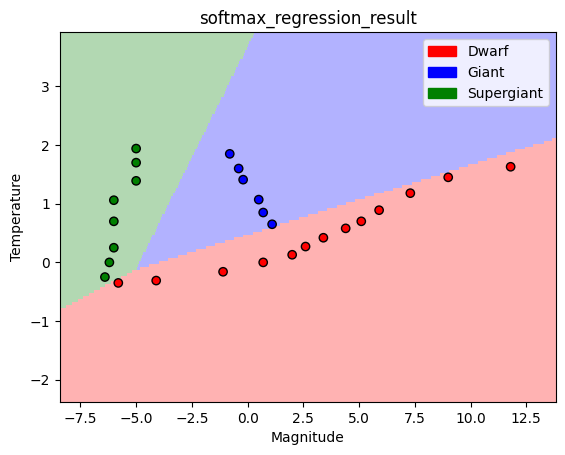

In [27]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result',
                   basis=None)

In [35]:
# test your models by passing your fitted models into the functions below
# softmax_model is an instance of class SoftmaxRegression fitted to data X_stars, y_stars
# basis_model is an instance of class SoftmaxRegression fitted to data phi(X_stars), y_stars
# knn1_model is an instance of class KNNClassifier with parameter k=1
# knn5_model is an instance of class KNNClassifier with parameter k=5
star = np.array([[3, -2]])

gaussian_model_shared = GaussianGenerativeModel(is_shared_covariance=True)
gaussian_model_shared.fit(X_stars, y_stars)

gaussian_model = GaussianGenerativeModel(is_shared_covariance=False)
gaussian_model.fit(X_stars, y_stars)

softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)

basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
basis_model.fit(phi(X_stars), y_stars)

knn_model_1 = KNNClassifier(k=1)
knn_model_1.fit(X_stars, y_stars)

knn_model_5 = KNNClassifier(k=5)
knn_model_5.fit(X_stars, y_stars)

print("Gaussian without shared cov matrix: ", gaussian_model.predict(star))
print("Gaussian shared cov matrix: ", gaussian_model_shared.predict(star))
print("Softmax Normal: ", softmax_model.predict_proba(star))
print("Softmax W/ Basis: ", basis_model.predict_proba(phi(star)))
print("kNN w/ k=1: ", knn_model_1.predict(star))
print("kNN w/ k=5: ", knn_model_5.predict(star))


[[6.18507992e-053]
 [8.05703396e-311]
 [0.00000000e+000]]
Gaussian without shared cov matrix:  [0]
[[2.98230700e-07]
 [1.37494191e-13]
 [2.74326307e-17]]
Gaussian shared cov matrix:  [0]
Softmax Normal:  [[1.00000000e+00 1.31778926e-28 2.56768493e-40]]
Softmax W/ Basis:  [[0.03425432 0.96455651 0.00118917]]
kNN w/ k=1:  [0]
kNN w/ k=5:  [0]


In [ ]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
knn5_model = KNNClassifier(k=5)
knn5_model.fit(X_stars, y_stars)
visualize_boundary(model=knn5_model,
                   X=X_stars,
                   y=y_stars,
                   title='KNN5_classifier_result',
                   basis=None)

In [ ]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
knn1_model = KNNClassifier(k=1)
knn1_model.fit(X_stars, y_stars)
visualize_boundary(model=knn1_model,
                   X=X_stars,
                   y=y_stars,
                   title='KNN1_classifier_result',
                   basis=None)

In [ ]:
test_p3_softmax(softmax_model, basis_model)
test_p3_knn(knn1_model, knn5_model)

[[1.46409110e-18 1.06718334e-18 7.76583894e-19 ... 1.86185756e-38
  3.03009714e-38 4.92317254e-38]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.49118546e-05 3.95718135e-05 6.00486960e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


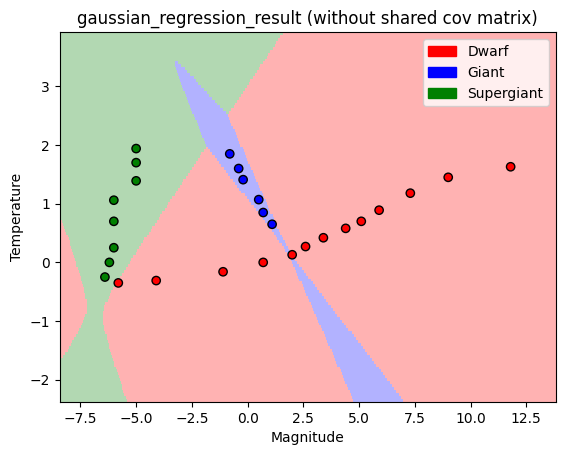

In [29]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
gaussian_model = GaussianGenerativeModel(is_shared_covariance=False)
gaussian_model.fit(X_stars, y_stars)
visualize_boundary(model=gaussian_model,
                   X=X_stars,
                   y=y_stars,
                   title='gaussian_regression_result (without shared cov matrix)',
                   basis=None)

[[8.74254786e-06 8.84183809e-06 8.93887485e-06 ... 1.70718210e-07
  1.72635780e-07 1.74508879e-07]
 [1.32352048e-08 1.28258337e-08 1.24244251e-08 ... 8.80383409e-06
  8.53047488e-06 8.26247820e-06]
 [3.48122156e-09 3.26131048e-09 3.05413611e-09 ... 9.60606297e-09
  8.99813143e-09 8.42548664e-09]]


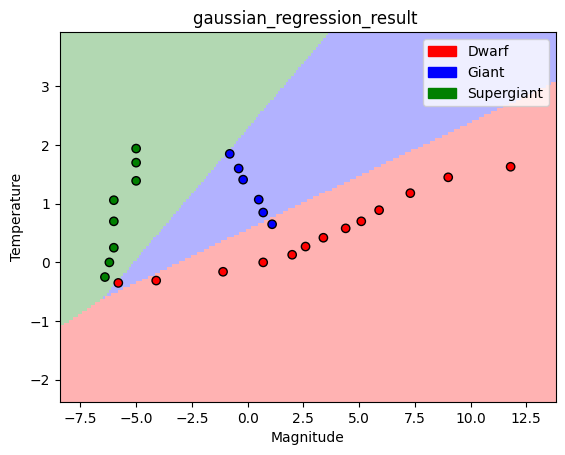

In [33]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
gaussian_model = GaussianGenerativeModel(is_shared_covariance=True)
gaussian_model.fit(X_stars, y_stars)
visualize_boundary(model=gaussian_model,
                   X=X_stars,
                   y=y_stars,
                   title='gaussian_regression_result ',
                   basis=None)

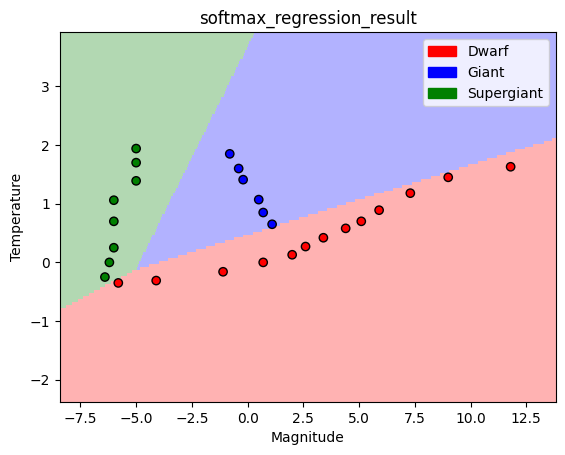

In [ ]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result',
                   basis=None)

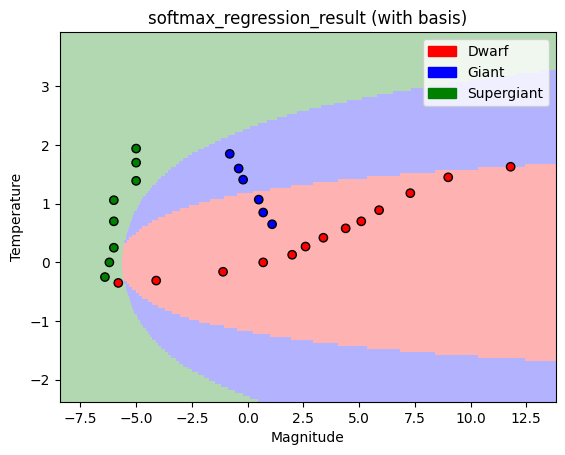

In [ ]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
basis_model.fit(phi(X_stars), y_stars)
visualize_boundary(model=basis_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result (with basis)',
                   basis=phi)